In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import scipy.cluster.hierarchy as sch

In [2]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from sklearn.pipeline import make_pipeline
from sklearn.metrics import precision_score, roc_auc_score, RocCurveDisplay, ConfusionMatrixDisplay, accuracy_score, calinski_harabasz_score
from factor_analyzer import FactorAnalyzer

In [3]:
from data.utils import add_experience, feature_classification, astype_category

In [4]:
# DataFrame 초기 세팅
hr_df = pd.read_csv(Path.cwd() / 'data' / 'HR-Employee-Attrition.csv')
hr_df = (hr_df
         .pipe(add_experience)
         .pipe(feature_classification, return_dataframe=True)
         .pipe(astype_category)
         .set_index('EmployeeNumber')
)
hr_df = (hr_df
         .assign(Attrition=lambda df: df['Attrition'].replace({'Yes':1, 'No':0}))
         .assign(OverTime=lambda df: df['OverTime'].replace({'Yes':1, 'No':0}))
)
hr_df.columns

Index(['MonthlyIncome', 'PercentSalaryHike', 'StockOptionLevel', 'Age',
       'Gender', 'MaritalStatus', 'Education', 'EducationField',
       'DistanceFromHome', 'NumCompaniesWorked', 'TotalWorkingYears',
       'Experienced', 'Department', 'BusinessTravel', 'JobLevel', 'JobRole',
       'JobInvolvement', 'OverTime', 'WorkLifeBalance',
       'TrainingTimesLastYear', 'YearsAtCompany', 'YearsInCurrentRole',
       'YearsSinceLastPromotion', 'YearsWithCurrManager',
       'EnvironmentSatisfaction', 'JobSatisfaction', 'PerformanceRating',
       'RelationshipSatisfaction', 'Attrition'],
      dtype='object')

In [5]:
# 필요 내용 category 변경 확인
hr_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1470 entries, 1 to 2068
Data columns (total 29 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   MonthlyIncome             1470 non-null   int64   
 1   PercentSalaryHike         1470 non-null   int64   
 2   StockOptionLevel          1470 non-null   int64   
 3   Age                       1470 non-null   int64   
 4   Gender                    1470 non-null   category
 5   MaritalStatus             1470 non-null   category
 6   Education                 1470 non-null   category
 7   EducationField            1470 non-null   category
 8   DistanceFromHome          1470 non-null   int64   
 9   NumCompaniesWorked        1470 non-null   int64   
 10  TotalWorkingYears         1470 non-null   int64   
 11  Experienced               1470 non-null   category
 12  Department                1470 non-null   category
 13  BusinessTravel            1470 non-null   catego

In [6]:
# categorical variables에 대한 one-hot encoding
hr_df_onehot = pd.get_dummies(hr_df, columns=['BusinessTravel', 'Department', 'Education', 'EducationField', 'EnvironmentSatisfaction',
                                              'Experienced', 'Gender', 'JobRole', 'MaritalStatus'])
hr_df_onehot

,MonthlyIncome,PercentSalaryHike,StockOptionLevel,Age,DistanceFromHome,NumCompaniesWorked,TotalWorkingYears,JobLevel,JobInvolvement,OverTime,...,JobRole_LaboratoryTechnician,JobRole_Manager,JobRole_ManufacturingDirector,JobRole_ResearchDirector,JobRole_ResearchScientist,JobRole_SalesExecutive,JobRole_SalesRepresentative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single
EmployeeNumber,,,,,,,,,,,,,,,,,,,,,
1,5993,11,0,41,1,8,8,2,3,1,...,0,0,0,0,0,1,0,0,0,1
2,5130,23,1,49,8,1,10,2,2,0,...,0,0,0,0,1,0,0,0,1,0
4,2090,15,0,37,2,6,7,1,2,1,...,1,0,0,0,0,0,0,0,0,1
5,2909,11,0,33,3,1,8,1,3,1,...,0,0,0,0,1,0,0,0,1,0
7,3468,12,1,27,2,9,6,1,3,0,...,1,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2061,2571,17,1,36,23,4,17,2,4,0,...,1,0,0,0,0,0,0,0,1,0
2062,9991,15,1,39,6,4,9,3,2,0,...,0,0,0,0,0,0,0,0,1,0
2064,6142,20,1,27,4,1,6,2,4,1,...,0,0,1,0,0,0,0,0,1,0


In [7]:
X = hr_df_onehot.drop('Attrition', axis=1)
y = hr_df_onehot['Attrition']
X.shape, y.shape

((1470, 57), (1470,))

In [8]:
# PolynomialFeatures는 각 요소들의 결합만 확인하도록 interaction_only 진행
poly = PolynomialFeatures(degree=3, interaction_only=True, include_bias=False).fit(X)
X_poly = poly.transform(X)

In [9]:
# X_poly를 DataFrame으로 변환 → Columns가 30,913개로 많으므로 조치 필요
X_poly = pd.DataFrame(X_poly, columns=poly.get_feature_names_out())
X_poly

,MonthlyIncome,PercentSalaryHike,StockOptionLevel,Age,DistanceFromHome,NumCompaniesWorked,TotalWorkingYears,JobLevel,JobInvolvement,OverTime,...,JobRole_SalesExecutive JobRole_SalesRepresentative MaritalStatus_Divorced,JobRole_SalesExecutive JobRole_SalesRepresentative MaritalStatus_Married,JobRole_SalesExecutive JobRole_SalesRepresentative MaritalStatus_Single,JobRole_SalesExecutive MaritalStatus_Divorced MaritalStatus_Married,JobRole_SalesExecutive MaritalStatus_Divorced MaritalStatus_Single,JobRole_SalesExecutive MaritalStatus_Married MaritalStatus_Single,JobRole_SalesRepresentative MaritalStatus_Divorced MaritalStatus_Married,JobRole_SalesRepresentative MaritalStatus_Divorced MaritalStatus_Single,JobRole_SalesRepresentative MaritalStatus_Married MaritalStatus_Single,MaritalStatus_Divorced MaritalStatus_Married MaritalStatus_Single
0,5993.0,11.0,0.0,41.0,1.0,8.0,8.0,2.0,3.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,5130.0,23.0,1.0,49.0,8.0,1.0,10.0,2.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2090.0,15.0,0.0,37.0,2.0,6.0,7.0,1.0,2.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2909.0,11.0,0.0,33.0,3.0,1.0,8.0,1.0,3.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3468.0,12.0,1.0,27.0,2.0,9.0,6.0,1.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1465,2571.0,17.0,1.0,36.0,23.0,4.0,17.0,2.0,4.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1466,9991.0,15.0,1.0,39.0,6.0,4.0,9.0,3.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1467,6142.0,20.0,1.0,27.0,4.0,1.0,6.0,2.0,4.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1468,5390.0,14.0,0.0,49.0,2.0,2.0,17.0,2.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
# 재직 중인 인원들만 대상으로 실제 test를 수행하기 위해 재직 인원들만 query 진행
# y를 다시 합칠 때 index가 맞춰져있어야 하므로 해당 작업 수행
attr_no = (X_poly
           .assign(EmpNum=X.index)
           .set_index('EmpNum')
           .assign(Attrition=y)
           .query("Attrition == 0")
)
attr_no

,MonthlyIncome,PercentSalaryHike,StockOptionLevel,Age,DistanceFromHome,NumCompaniesWorked,TotalWorkingYears,JobLevel,JobInvolvement,OverTime,...,JobRole_SalesExecutive JobRole_SalesRepresentative MaritalStatus_Married,JobRole_SalesExecutive JobRole_SalesRepresentative MaritalStatus_Single,JobRole_SalesExecutive MaritalStatus_Divorced MaritalStatus_Married,JobRole_SalesExecutive MaritalStatus_Divorced MaritalStatus_Single,JobRole_SalesExecutive MaritalStatus_Married MaritalStatus_Single,JobRole_SalesRepresentative MaritalStatus_Divorced MaritalStatus_Married,JobRole_SalesRepresentative MaritalStatus_Divorced MaritalStatus_Single,JobRole_SalesRepresentative MaritalStatus_Married MaritalStatus_Single,MaritalStatus_Divorced MaritalStatus_Married MaritalStatus_Single,Attrition
EmpNum,,,,,,,,,,,,,,,,,,,,,
2,5130.0,23.0,1.0,49.0,8.0,1.0,10.0,2.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
5,2909.0,11.0,0.0,33.0,3.0,1.0,8.0,1.0,3.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
7,3468.0,12.0,1.0,27.0,2.0,9.0,6.0,1.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
8,3068.0,13.0,0.0,32.0,2.0,0.0,8.0,1.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
10,2670.0,20.0,3.0,59.0,3.0,4.0,12.0,1.0,4.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2061,2571.0,17.0,1.0,36.0,23.0,4.0,17.0,2.0,4.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2062,9991.0,15.0,1.0,39.0,6.0,4.0,9.0,3.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2064,6142.0,20.0,1.0,27.0,4.0,1.0,6.0,2.0,4.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [11]:
# train set과 test set 구분
# 참고 : 여기서는 좀 더 정확하게 dataset 구분 후 StandardScaler 진행 예정
X_train, X_test, y_train, y_test = train_test_split(X_poly, y, random_state=0)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1102, 30913), (368, 30913), (1102,), (368,))

In [12]:
# StandardScaler 수행
scaler = StandardScaler().fit(X_train)
X_train_sc = scaler.transform(X_train)
X_test_sc = scaler.transform(X_test)

In [13]:
# LogisticRegression 수행
# Features가 많으므로 L1 Regularization 진행하고 Regularization의 강도를 높이는 형태
# Baseline보다 더 높은 roc_auc_score를 보여줌
logreg = LogisticRegression(max_iter=1000, C=0.03, penalty='l1', solver='liblinear').fit(X_train_sc, y_train)
logreg.score(X_test_sc, y_test), roc_auc_score(y_test, logreg.predict_proba(X_test_sc)[:, 1])

(0.8559782608695652, 0.7924916573971079)

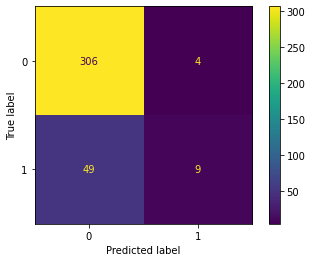

In [14]:
# confusion matrix는 다소 불만족스러우나, roc_auc_score가 높으므로 cutoff 조정 가능
ConfusionMatrixDisplay.from_predictions(y_test, logreg.predict(X_test_sc))

In [15]:
# cutoff를 0.65을 기준으로 → 최대한 accuracy가 유지되는 선에서 Attrition할 것이란 예측을 극대화
y_hat = np.where(logreg.predict_proba(X_test_sc)[:, 0] >= 0.65, 0, 1)
y_hat

array([0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,

0.8641304347826086


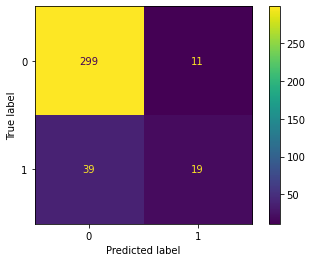

In [16]:
# prediction proba 0.65 기준 confusion matrix와 accuracy score 확인
ConfusionMatrixDisplay.from_predictions(y_test, y_hat)
print(accuracy_score(y_test, y_hat))

In [17]:
# 일정 수준 이상의 coef만 출력하여 확인
X_coef = (pd.DataFrame(logreg.coef_.T, index=X_poly.columns, columns=['Coefficient'])
          .query("Coefficient > 0.07 or Coefficient < -0.07")
          .reset_index()
)
X_coef

,index,Coefficient
0,Age JobInvolvement,-0.073654
1,NumCompaniesWorked EnvironmentSatisfaction_1,0.070232
2,WorkLifeBalance YearsWithCurrManager,-0.091344
3,Age JobInvolvement JobSatisfaction,-0.091696
4,DistanceFromHome OverTime PerformanceRating,0.091334
5,NumCompaniesWorked OverTime Gender_Male,0.099844
6,NumCompaniesWorked EnvironmentSatisfaction_1 E...,0.072153
7,OverTime PerformanceRating MaritalStatus_Single,0.108798
8,OverTime Education_3 JobRole_LaboratoryTechnician,0.122560
9,OverTime Experienced_FreqMove Gender_Male,0.095316


In [18]:
coef_col_imsi = np.sort(X_coef['index'].str.split(' ', expand=True).replace({None:'ZZZ'}).values, axis=1)
coef_col_imsi

array([['Age', 'JobInvolvement', 'ZZZ'],
       ['EnvironmentSatisfaction_1', 'NumCompaniesWorked', 'ZZZ'],
       ['WorkLifeBalance', 'YearsWithCurrManager', 'ZZZ'],
       ['Age', 'JobInvolvement', 'JobSatisfaction'],
       ['DistanceFromHome', 'OverTime', 'PerformanceRating'],
       ['Gender_Male', 'NumCompaniesWorked', 'OverTime'],
       ['EnvironmentSatisfaction_1', 'Experienced_FreqMove',
        'NumCompaniesWorked'],
       ['MaritalStatus_Single', 'OverTime', 'PerformanceRating'],
       ['Education_3', 'JobRole_LaboratoryTechnician', 'OverTime'],
       ['Experienced_FreqMove', 'Gender_Male', 'OverTime'],
       ['EducationField_LifeSciences', 'JobRole_LaboratoryTechnician',
        'MaritalStatus_Single'],
       ['Experienced_FreqMove', 'JobRole_SalesRepresentative',
        'MaritalStatus_Single']], dtype=object)

In [19]:
# 모델에 영향을 미치는 Feature들을 추출한 후 확인
# negative 영향 : Age-JobInvolvement / HighWLB
# positive 영향 : LowEnvSatis-FreqMove / FreqMove-LowWLB / FreqMove-Sales / Single-LowWLB
X_coef_df = (pd.concat([pd.DataFrame(coef_col_imsi), X_coef.drop('index', axis=1)], axis=1)
             .rename({0:'Feat1', 1:'Feat2', 2:'Feat3'}, axis=1)
             .sort_values(by=['Feat1', 'Feat2', 'Feat3'])
             .replace({'ZZZ':None})
)
X_coef_df

,Feat1,Feat2,Feat3,Coefficient
3,Age,JobInvolvement,JobSatisfaction,-0.091696
0,Age,JobInvolvement,None,-0.073654
4,DistanceFromHome,OverTime,PerformanceRating,0.091334
10,EducationField_LifeSciences,JobRole_LaboratoryTechnician,MaritalStatus_Single,0.097538
8,Education_3,JobRole_LaboratoryTechnician,OverTime,0.122560
6,EnvironmentSatisfaction_1,Experienced_FreqMove,NumCompaniesWorked,0.072153
1,EnvironmentSatisfaction_1,NumCompaniesWorked,None,0.070232
9,Experienced_FreqMove,Gender_Male,OverTime,0.095316
11,Experienced_FreqMove,JobRole_SalesRepresentative,MaritalStatus_Single,0.107099
5,Gender_Male,NumCompaniesWorked,OverTime,0.099844


In [20]:
# 재직 중인 인원만 모델링의 test set로 삼기 위해 가져오기
attr_no

,MonthlyIncome,PercentSalaryHike,StockOptionLevel,Age,DistanceFromHome,NumCompaniesWorked,TotalWorkingYears,JobLevel,JobInvolvement,OverTime,...,JobRole_SalesExecutive JobRole_SalesRepresentative MaritalStatus_Married,JobRole_SalesExecutive JobRole_SalesRepresentative MaritalStatus_Single,JobRole_SalesExecutive MaritalStatus_Divorced MaritalStatus_Married,JobRole_SalesExecutive MaritalStatus_Divorced MaritalStatus_Single,JobRole_SalesExecutive MaritalStatus_Married MaritalStatus_Single,JobRole_SalesRepresentative MaritalStatus_Divorced MaritalStatus_Married,JobRole_SalesRepresentative MaritalStatus_Divorced MaritalStatus_Single,JobRole_SalesRepresentative MaritalStatus_Married MaritalStatus_Single,MaritalStatus_Divorced MaritalStatus_Married MaritalStatus_Single,Attrition
EmpNum,,,,,,,,,,,,,,,,,,,,,
2,5130.0,23.0,1.0,49.0,8.0,1.0,10.0,2.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
5,2909.0,11.0,0.0,33.0,3.0,1.0,8.0,1.0,3.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
7,3468.0,12.0,1.0,27.0,2.0,9.0,6.0,1.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
8,3068.0,13.0,0.0,32.0,2.0,0.0,8.0,1.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
10,2670.0,20.0,3.0,59.0,3.0,4.0,12.0,1.0,4.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2061,2571.0,17.0,1.0,36.0,23.0,4.0,17.0,2.0,4.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2062,9991.0,15.0,1.0,39.0,6.0,4.0,9.0,3.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2064,6142.0,20.0,1.0,27.0,4.0,1.0,6.0,2.0,4.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [21]:
# 모두 재직 중이므로 Attrition Feature 제외
X_attr_no = attr_no.drop('Attrition', axis=1)
X_attr_no

,MonthlyIncome,PercentSalaryHike,StockOptionLevel,Age,DistanceFromHome,NumCompaniesWorked,TotalWorkingYears,JobLevel,JobInvolvement,OverTime,...,JobRole_SalesExecutive JobRole_SalesRepresentative MaritalStatus_Divorced,JobRole_SalesExecutive JobRole_SalesRepresentative MaritalStatus_Married,JobRole_SalesExecutive JobRole_SalesRepresentative MaritalStatus_Single,JobRole_SalesExecutive MaritalStatus_Divorced MaritalStatus_Married,JobRole_SalesExecutive MaritalStatus_Divorced MaritalStatus_Single,JobRole_SalesExecutive MaritalStatus_Married MaritalStatus_Single,JobRole_SalesRepresentative MaritalStatus_Divorced MaritalStatus_Married,JobRole_SalesRepresentative MaritalStatus_Divorced MaritalStatus_Single,JobRole_SalesRepresentative MaritalStatus_Married MaritalStatus_Single,MaritalStatus_Divorced MaritalStatus_Married MaritalStatus_Single
EmpNum,,,,,,,,,,,,,,,,,,,,,
2,5130.0,23.0,1.0,49.0,8.0,1.0,10.0,2.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,2909.0,11.0,0.0,33.0,3.0,1.0,8.0,1.0,3.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,3468.0,12.0,1.0,27.0,2.0,9.0,6.0,1.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,3068.0,13.0,0.0,32.0,2.0,0.0,8.0,1.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,2670.0,20.0,3.0,59.0,3.0,4.0,12.0,1.0,4.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2061,2571.0,17.0,1.0,36.0,23.0,4.0,17.0,2.0,4.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2062,9991.0,15.0,1.0,39.0,6.0,4.0,9.0,3.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2064,6142.0,20.0,1.0,27.0,4.0,1.0,6.0,2.0,4.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [22]:
# StandardScaler 수행 → 기존 X_train에서 진행되었던걸 그대로 수행해야
X_attr_no_sc = scaler.transform(X_attr_no)
X_attr_no_sc

array([[-0.28600688,  2.14589337,  0.22713711, ...,  0.        ,
         0.        ,  0.        ],
       [-0.75651364, -1.14194047, -0.93707262, ...,  0.        ,
         0.        ,  0.        ],
       [-0.63809253, -0.86795432,  0.22713711, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-0.07162019,  1.32393491,  0.22713711, ...,  0.        ,
         0.        ,  0.        ],
       [-0.23092729, -0.31998201, -0.93707262, ...,  0.        ,
         0.        ,  0.        ],
       [-0.43980603, -0.86795432, -0.93707262, ...,  0.        ,
         0.        ,  0.        ]])

In [23]:
# 학습된 LogisticRegression을 StandardScale된 X_attr_no_sc에 적용하여 예측
# 재직자를 대상으로 학습된 모델을 적용하면 당연히 Attrition 대상이 적을 수 밖에 없음 → predict_proba를 통해 cutoff를 0.7로 조정
# 학습 모델에서 cutoff=0.7까지는 Attrition 대상자의 accuracy가 용납 가능한 정도
y_hat = np.where(logreg.predict_proba(X_attr_no_sc)[:, 0] >= 0.7, 0, 1)
y_hat.sum()

60

In [24]:
# 재직자 중 Attrition이 예상되는 인원만 추출하여 DataFrame화
X_attr_pred = (X_attr_no
               .reset_index()
               .assign(AttritionPred=y_hat)
               .set_index('EmpNum')
               .query("AttritionPred == 1")
)
X_attr_pred

,MonthlyIncome,PercentSalaryHike,StockOptionLevel,Age,DistanceFromHome,NumCompaniesWorked,TotalWorkingYears,JobLevel,JobInvolvement,OverTime,...,JobRole_SalesExecutive JobRole_SalesRepresentative MaritalStatus_Married,JobRole_SalesExecutive JobRole_SalesRepresentative MaritalStatus_Single,JobRole_SalesExecutive MaritalStatus_Divorced MaritalStatus_Married,JobRole_SalesExecutive MaritalStatus_Divorced MaritalStatus_Single,JobRole_SalesExecutive MaritalStatus_Married MaritalStatus_Single,JobRole_SalesRepresentative MaritalStatus_Divorced MaritalStatus_Married,JobRole_SalesRepresentative MaritalStatus_Divorced MaritalStatus_Single,JobRole_SalesRepresentative MaritalStatus_Married MaritalStatus_Single,MaritalStatus_Divorced MaritalStatus_Married MaritalStatus_Single,AttritionPred
EmpNum,,,,,,,,,,,,,,,,,,,,,
7,3468.0,12.0,1.0,27.0,2.0,9.0,6.0,1.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
15,4193.0,12.0,0.0,29.0,15.0,0.0,10.0,2.0,2.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
24,3944.0,11.0,0.0,38.0,2.0,5.0,6.0,1.0,3.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
62,5772.0,21.0,0.0,46.0,5.0,4.0,14.0,2.0,3.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
120,5441.0,22.0,0.0,51.0,21.0,0.0,11.0,2.0,3.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
193,4317.0,20.0,0.0,38.0,3.0,3.0,19.0,2.0,3.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
329,19068.0,18.0,0.0,52.0,2.0,1.0,33.0,5.0,2.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
411,1200.0,12.0,0.0,18.0,10.0,1.0,0.0,1.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
437,4478.0,11.0,0.0,27.0,2.0,1.0,5.0,2.0,3.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [25]:
# 수많은 Feature들 중 X_coef에서 나온 유의미한 Feature들만 추출
X_attr_pred_part = X_attr_pred[X_coef['index'].to_list()]
X_attr_pred_part

,Age JobInvolvement,NumCompaniesWorked EnvironmentSatisfaction_1,WorkLifeBalance YearsWithCurrManager,Age JobInvolvement JobSatisfaction,DistanceFromHome OverTime PerformanceRating,NumCompaniesWorked OverTime Gender_Male,NumCompaniesWorked EnvironmentSatisfaction_1 Experienced_FreqMove,OverTime PerformanceRating MaritalStatus_Single,OverTime Education_3 JobRole_LaboratoryTechnician,OverTime Experienced_FreqMove Gender_Male,EducationField_LifeSciences JobRole_LaboratoryTechnician MaritalStatus_Single,Experienced_FreqMove JobRole_SalesRepresentative MaritalStatus_Single
EmpNum,,,,,,,,,,,,
7,81.0,9.0,6.0,162.0,0.0,0.0,9.0,0.0,0.0,0.0,0.0,0.0
15,58.0,0.0,24.0,174.0,45.0,0.0,0.0,3.0,0.0,0.0,1.0,0.0
24,114.0,0.0,6.0,456.0,6.0,5.0,0.0,3.0,0.0,1.0,0.0,0.0
62,138.0,4.0,24.0,552.0,20.0,4.0,0.0,4.0,0.0,0.0,0.0,0.0
120,153.0,0.0,0.0,612.0,84.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0
193,114.0,0.0,6.0,342.0,12.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0
329,104.0,1.0,48.0,312.0,6.0,1.0,1.0,3.0,0.0,1.0,0.0,0.0
411,36.0,0.0,0.0,108.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
437,81.0,0.0,12.0,243.0,6.0,1.0,0.0,3.0,0.0,1.0,0.0,0.0


In [27]:
# K-Means Clustering을 위한 StandardScaler 진행
# 전체 대비를 파악해야하므로 X_poly가 고려된 scaler를 적용
scaler = StandardScaler().fit(X_poly[X_coef['index'].to_list()])
X_attr_part_sc = scaler.transform(X_attr_pred_part)

c:\Users\admin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\admin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\admin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\admin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\admin\anaconda3\lib\site-packages\sklearn\clust

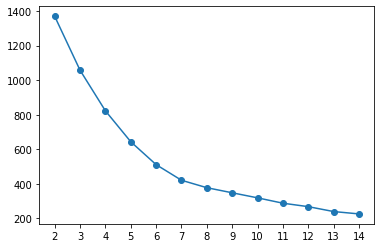

In [28]:
# 적정 cluster 수 파악을 위한 elbow graph 확인
# kmeans를 통해서는 딱 떨어지는 cluster 수를 파악하기 힘듦
inertias = []
for i in range(2, 15):
    kmeans = KMeans(n_clusters=i).fit(X_attr_part_sc)
    inertias.append(kmeans.inertia_)
plt.plot(inertias, marker='o')
plt.xticks(ticks=range(13), labels=range(2, 15))
plt.show()

In [29]:
# 참고용으로 calinski-harabasz score 확인
# 3개 cluster가 그나마 적절
for i in range(2, 15):
    kmeans = KMeans(n_clusters=i, random_state=0).fit(X_attr_part_sc)
    print(calinski_harabasz_score(X_attr_part_sc, kmeans.labels_))

c:\Users\admin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\admin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\admin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\admin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\admin\anaconda3\lib\site-packages\sklearn\clust

23.051177728344236
23.080022385810263
24.762280660119348
27.132771004811662
29.571761232606793
31.329732860125958
29.828934306760324
28.656474218576918
27.79826084293688
27.64498453577252
27.36559338529874
26.49917539515479
26.707119284817747


c:\Users\admin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\admin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\admin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


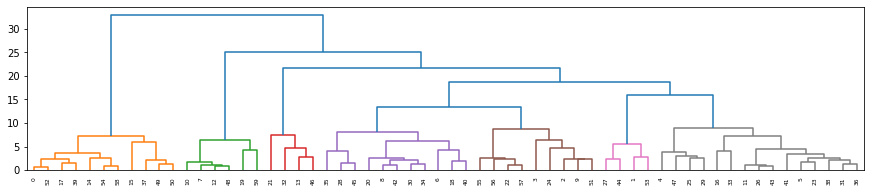

In [30]:
# 혹시 모르니 hierachical clustering도 진행
# ward method로 확인
cluster = sch.linkage(X_attr_part_sc, method='ward', metric='euclidean')
plt.figure(figsize=(15, 3))
sch.dendrogram(cluster, color_threshold=10)
plt.show()

In [34]:
# hierachical clustering을 통한 작업을 적용
assignments = sch.fcluster(cluster, t=10, criterion='distance')
assignments
# 참고 K-Means를 통한 작업
#kmeans = KMeans(n_clusters=7, random_state=0).fit(X_attr_part_sc)
#assignments = kmeans.labels_
#assignments

array([1, 6, 5, 5, 7, 7, 4, 2, 4, 5, 2, 7, 2, 3, 1, 1, 7, 1, 4, 2, 4, 3,
       5, 7, 5, 7, 7, 6, 4, 7, 4, 7, 3, 7, 4, 4, 7, 1, 7, 1, 4, 7, 4, 7,
       6, 4, 3, 7, 2, 1, 1, 5, 1, 6, 1, 5, 5, 5, 1, 2], dtype=int32)

In [35]:
X_attr_cluster = (X_attr_pred_part
                  .reset_index()
                  .assign(cluster=assignments)
                  .set_index('EmpNum')
                  .sort_values(by='cluster', ascending=True)
)
X_attr_cluster

,Age JobInvolvement,NumCompaniesWorked EnvironmentSatisfaction_1,WorkLifeBalance YearsWithCurrManager,Age JobInvolvement JobSatisfaction,DistanceFromHome OverTime PerformanceRating,NumCompaniesWorked OverTime Gender_Male,NumCompaniesWorked EnvironmentSatisfaction_1 Experienced_FreqMove,OverTime PerformanceRating MaritalStatus_Single,OverTime Education_3 JobRole_LaboratoryTechnician,OverTime Experienced_FreqMove Gender_Male,EducationField_LifeSciences JobRole_LaboratoryTechnician MaritalStatus_Single,Experienced_FreqMove JobRole_SalesRepresentative MaritalStatus_Single,cluster
EmpNum,,,,,,,,,,,,,
7,81.0,9.0,6.0,162.0,0.0,0.0,9.0,0.0,0.0,0.0,0.0,0.0,1
1916,124.0,8.0,4.0,372.0,0.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,1
1816,90.0,9.0,6.0,270.0,0.0,0.0,9.0,0.0,0.0,0.0,0.0,0.0,1
1720,96.0,6.0,6.0,288.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,1
1694,110.0,5.0,6.0,220.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,1
1502,66.0,8.0,6.0,132.0,0.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,1
1415,75.0,4.0,4.0,300.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,1
2012,120.0,8.0,0.0,480.0,0.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,1
854,100.0,7.0,2.0,100.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,1


In [36]:
# 좀 더 손쉬운 파악을 위한 Factor analysis 진행
cumul_var_list = []
for i in range(3, 10):
    fa = FactorAnalyzer(n_factors=i, method='principal', rotation='varimax').fit(X_attr_part_sc)
    cumul_var_list.append(fa.get_factor_variance()[2][i-1])
np.array(cumul_var_list)

array([0.53098997, 0.64410875, 0.73092931, 0.81323298, 0.87383025,
       0.92314557, 0.95752916])

In [37]:
# Variance 설명량이 80%가 넘는 n_factors를 선택하여 Factor Loadings 확인
n_factors = 6
fa = FactorAnalyzer(n_factors=n_factors, method='principal', rotation='varimax').fit(X_attr_part_sc)
fl_matrix = pd.DataFrame(fa.loadings_, columns=[f'Factor{i:02}' for i in range(1, n_factors + 1)], index=X_attr_pred_part.columns)
fl_matrix

,Factor01,Factor02,Factor03,Factor04,Factor05,Factor06
Age JobInvolvement,0.221651,0.799089,0.135469,0.077208,0.114924,0.107923
NumCompaniesWorked EnvironmentSatisfaction_1,0.942746,0.133277,-0.004035,-0.195379,-0.082191,0.014372
WorkLifeBalance YearsWithCurrManager,-0.049877,-0.053035,0.908158,0.040687,0.082972,0.007934
Age JobInvolvement JobSatisfaction,-0.118637,0.819019,-0.232283,-0.041921,-0.161539,0.038582
DistanceFromHome OverTime PerformanceRating,-0.429370,0.383589,0.312563,0.078886,0.130225,-0.081655
NumCompaniesWorked OverTime Gender_Male,-0.180655,0.244392,-0.188792,0.853533,-0.081218,0.044493
NumCompaniesWorked EnvironmentSatisfaction_1 Experienced_FreqMove,0.940190,0.088602,0.021230,-0.163465,-0.061607,0.047281
OverTime PerformanceRating MaritalStatus_Single,-0.583318,0.348478,0.431269,-0.087870,-0.403233,0.055371
OverTime Education_3 JobRole_LaboratoryTechnician,-0.116518,0.024061,0.099530,-0.038000,0.944549,0.044951
OverTime Experienced_FreqMove Gender_Male,-0.198184,-0.179607,0.302327,0.819232,0.048555,0.130049


In [38]:
# 각 Columns가 어떤 Factor에 속하는지, 그 Factor에서의 Factor Loadings는 어떻게 되는지 확인
fl_df = (pd.concat([fl_matrix.idxmax(axis=1), fl_matrix.max(axis=1)], axis=1)
         .rename({0:'Idxmax', 1:'Max'}, axis=1)
         .sort_values(by='Idxmax', ascending=True)
)
fl_df

,Idxmax,Max
NumCompaniesWorked EnvironmentSatisfaction_1,Factor01,0.942746
NumCompaniesWorked EnvironmentSatisfaction_1 Experienced_FreqMove,Factor01,0.940190
Age JobInvolvement,Factor02,0.799089
Age JobInvolvement JobSatisfaction,Factor02,0.819019
DistanceFromHome OverTime PerformanceRating,Factor02,0.383589
WorkLifeBalance YearsWithCurrManager,Factor03,0.908158
OverTime PerformanceRating MaritalStatus_Single,Factor03,0.431269
EducationField_LifeSciences JobRole_LaboratoryTechnician MaritalStatus_Single,Factor03,-0.060660
NumCompaniesWorked OverTime Gender_Male,Factor04,0.853533
OverTime Experienced_FreqMove Gender_Male,Factor04,0.819232


In [39]:
# Factor들에 대한 해석
factor_interpret = {'Factor01':'FreqMove_NotEnvSat', 'Factor02':'Age_JobInvolvement', 'Factor03':'HighWLB_etc',
                    'Factor04':'Male_OverTime_FreqMove', 'Factor05':'OverTime_Technician', 'Factor06':'Sales_FreqMove'}

In [45]:
X_attr_fa = pd.DataFrame(fa.transform(X_attr_part_sc), columns=factor_interpret.values(), index=X_attr_pred_part.index)
X_attr_fa

,FreqMove_NotEnvSat,Age_JobInvolvement,HighWLB_etc,Male_OverTime_FreqMove,OverTime_Technician,Sales_FreqMove
EmpNum,,,,,,
7,2.451677,-0.394621,0.061988,-0.322602,-0.231737,0.027325
15,-0.972306,-0.628340,1.143230,-1.003960,-0.486536,-3.296652
24,-0.489328,1.027701,-0.541596,1.430486,-0.613338,0.258304
62,-0.225921,2.145591,0.626502,-0.205045,-0.789972,0.374266
120,-1.381770,3.130982,-0.293401,-1.217645,-0.139195,0.203203
193,-0.718516,0.956540,0.035049,-0.891908,-0.551667,0.234964
329,0.059389,-0.116360,2.839089,0.374896,-0.628526,0.494520
411,-0.661293,-2.019520,-1.453810,-0.991955,-0.146054,1.305432
437,-0.405848,-0.371257,0.562106,0.593457,-0.544966,0.206848


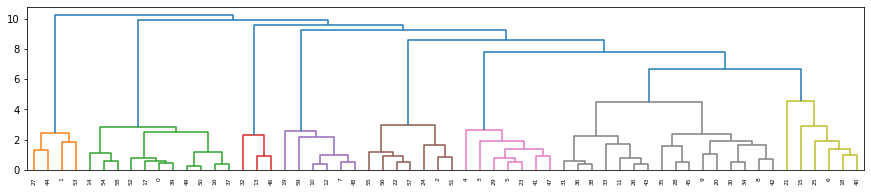

In [43]:
# Factor analysis 완료된 자료로 다시 hierachical clustering도 진행
# ward method로 확인
cluster = sch.linkage(X_attr_fa, method='ward', metric='euclidean')
plt.figure(figsize=(15, 3))
sch.dendrogram(cluster, color_threshold=6)
plt.show()

In [44]:
# hierachical clustering을 통한 작업을 적용
assignments = sch.fcluster(cluster, t=6, criterion='distance')
assignments
# 참고 K-Means를 통한 작업
#kmeans = KMeans(n_clusters=7, random_state=0).fit(X_attr_fa)
#assignments = kmeans.labels_
#assignments

array([2, 1, 5, 6, 6, 6, 8, 4, 7, 7, 4, 7, 4, 3, 2, 8, 2, 2, 8, 4, 7, 8,
       5, 6, 5, 8, 7, 1, 7, 6, 7, 7, 3, 7, 7, 7, 7, 2, 7, 2, 8, 6, 7, 7,
       1, 7, 3, 6, 4, 2, 2, 5, 2, 1, 2, 5, 5, 5, 2, 4], dtype=int32)

In [46]:
# 최종 cluster 확인 → Factor analysis로 인해 내용 파악 용이
X_attr_fa_cluster = (X_attr_fa
                     .reset_index()
                     .assign(cluster=assignments)
                     .set_index('EmpNum')
                     .sort_values(by='cluster', ascending=True)
)
X_attr_fa_cluster

,FreqMove_NotEnvSat,Age_JobInvolvement,HighWLB_etc,Male_OverTime_FreqMove,OverTime_Technician,Sales_FreqMove,cluster
EmpNum,,,,,,,
1659,0.094678,-0.320532,-0.624255,-0.524617,0.134797,-3.276969,1
1850,-0.906292,0.132222,-0.560248,-0.944509,-0.570903,-3.209039,1
1198,-0.039285,-1.544762,-0.866595,-0.424251,-0.083046,-3.524615,1
15,-0.972306,-0.628340,1.143230,-1.003960,-0.486536,-3.296652,1
1816,2.392623,0.110466,-0.114800,-0.395652,-0.248553,0.082486,2
1720,1.579367,0.179262,-0.338416,-0.391823,-0.070115,0.048989,2
1694,1.398802,0.101736,-0.265211,-0.342253,0.076202,0.055715,2
854,1.987904,-0.372384,-0.190257,-0.253742,-0.003488,0.012001,2
1502,2.161699,-0.729337,0.025870,-0.295620,-0.224693,-0.045143,2


In [47]:
# 내용 확인
# cluster 1 : Age, JobInvolvement, WLB 등에 문제가 생긴 케이스
# cluster 2 : 기존 이직이 잦았으며, 업무환경에 대하여 불만족한 케이스. Sales 쪽에 주로 있을지도
# cluster 3 : Technician 쪽에서 OverTime이 잦은 케이스
# cluster 4 : Sales 쪽에서 이직이 잦았으며, 워라밸이 안좋은 케이스
# cluster 5 : 기존 이직이 잦았으며 OverTime이 많은 남자 케이스. Age와 JobInvolvement는 괜찮음
# cluster 6 : 현재 데이터로는 이유를 크게 알 수 없는 케이스
#    - Age, JobInvolvement도 준수하고, WLB도 괜찮음 → 여자이면서 개인 사유일 가능성?
# cluster 7 : 현재 데이터로는 이유를 크게 알 수 없는 복합적 사유의 케이스
# cluster 8 : 현재 Manager와 같이 일을 많이 한 케이스. 이유 파악을 위해서는 세부적으로 확인 필요
X_attr_fa_cluster

,FreqMove_NotEnvSat,Age_JobInvolvement,HighWLB_etc,Male_OverTime_FreqMove,OverTime_Technician,Sales_FreqMove,cluster
EmpNum,,,,,,,
1659,0.094678,-0.320532,-0.624255,-0.524617,0.134797,-3.276969,1
1850,-0.906292,0.132222,-0.560248,-0.944509,-0.570903,-3.209039,1
1198,-0.039285,-1.544762,-0.866595,-0.424251,-0.083046,-3.524615,1
15,-0.972306,-0.628340,1.143230,-1.003960,-0.486536,-3.296652,1
1816,2.392623,0.110466,-0.114800,-0.395652,-0.248553,0.082486,2
1720,1.579367,0.179262,-0.338416,-0.391823,-0.070115,0.048989,2
1694,1.398802,0.101736,-0.265211,-0.342253,0.076202,0.055715,2
854,1.987904,-0.372384,-0.190257,-0.253742,-0.003488,0.012001,2
1502,2.161699,-0.729337,0.025870,-0.295620,-0.224693,-0.045143,2
